# Reclasificación de AGEBS
Este es un nuevo repositorio para la reclasificación de AGEBS. El objetivo es crear un nuevo conjunto de AGEBS que sea más homogéneo y que permita una mejor comparación entre las diferentes variables de interés.

## Carga de librerías

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob

## Carga de datos

In [298]:
rename_quimicos = {
  'co': '$CO$',
  'hcho': '$HCHO$',
  'o3': '$O_3$',
  'so2': '$SO_2$',
  'no2': '$NO_2$'
}

### Datos de SENTINEL

In [299]:
sentinel_dir = "data/sentinel/AGEBS/month/*.csv"
sentinel_files = glob.glob(sentinel_dir)
sentinel_files.sort()
sentinel_files[:5]

['data/sentinel/AGEBS/month\\sum_CO_2018-11-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2018-12-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2019-01-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2019-02-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2019-03-01.csv']

In [300]:
pd.read_csv(sentinel_files[0]).head()

,sum,CVE_LOC,CVE_MUN,CVE_ENT,CVEGEO,CVE_AGEB,system:index
0,0.052075,1,1,6,0600100010081,0081,00000000000000000000
1,0.023302,1,1,6,060010001019A,019A,00000000000000000001
2,0.008745,1,1,6,0600100010359,0359,00000000000000000002
3,0.077275,1,1,6,0600100010151,0151,00000000000000000003
4,0.076924,1,1,6,0600100010166,0166,00000000000000000004


In [301]:
sentinel_files[0].split("\\")[1].split("_")[1]

'CO'

In [302]:
def read_sentinel(files):
  df_full = pd.DataFrame()
  for f in files:
    quimico = f.split("\\")[1].split("_")[1]
    quimico = rename_quimicos[quimico.lower()]

    date = f.split("\\")[1].split("_")[2].split(".")[0]
    cols_to_keep = ["CVEGEO", "sum"]
    df = pd.read_csv(f, usecols=cols_to_keep)
    
    df["quimico"] = quimico
    df["date"] = date
    df_full = pd.concat([df_full, df])
  return df_full

df_sentinel = read_sentinel(sentinel_files)
df_sentinel.head()

,sum,CVEGEO,quimico,date
0,0.052075,0600100010081,$CO$,2018-11-01
1,0.023302,060010001019A,$CO$,2018-11-01
2,0.008745,0600100010359,$CO$,2018-11-01
3,0.077275,0600100010151,$CO$,2018-11-01
4,0.076924,0600100010166,$CO$,2018-11-01


In [303]:
# set df_sentinel from long to wide
df_sentinel_pivot = pd.pivot_table(df_sentinel,index=["CVEGEO", "date"],columns="quimico", values="sum").dropna()
df_sentinel_pivot.reset_index(inplace=True)
df_sentinel_pivot.head()

quimico,CVEGEO,date,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$
0,0600100010081,2018-11-01,0.052075,0.000757,0.000491,1.018031,0.000308
1,0600100010081,2018-12-01,0.151151,0.001729,0.000560,1.030936,-0.000026
2,0600100010081,2019-01-01,0.211080,0.001839,0.000570,1.048855,0.001457
3,0600100010081,2019-02-01,0.226947,0.001311,0.000558,0.991918,0.001848
4,0600100010081,2019-03-01,0.272456,0.001478,0.000607,1.135778,0.001786


In [304]:
# df_sentinel_pivot from monthly to yearly
df_sentinel_pivot["year"] = df_sentinel_pivot["date"].apply(lambda x: x[:4])
df_sentinel_pivot.head()

quimico,CVEGEO,date,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,year
0,0600100010081,2018-11-01,0.052075,0.000757,0.000491,1.018031,0.000308,2018
1,0600100010081,2018-12-01,0.151151,0.001729,0.000560,1.030936,-0.000026,2018
2,0600100010081,2019-01-01,0.211080,0.001839,0.000570,1.048855,0.001457,2019
3,0600100010081,2019-02-01,0.226947,0.001311,0.000558,0.991918,0.001848,2019
4,0600100010081,2019-03-01,0.272456,0.001478,0.000607,1.135778,0.001786,2019


In [305]:
# count months per year per ageb
df_sentinel_pivot["count"] = df_sentinel_pivot.groupby(["CVEGEO", "year"])["date"].transform("count")
df_sentinel_pivot = df_sentinel_pivot[df_sentinel_pivot["count"] > 10]
df_sentinel_pivot

quimico,CVEGEO,date,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,year,count
2,0600100010081,2019-01-01,0.211080,0.001839,0.000570,1.048855,0.001457,2019,12
3,0600100010081,2019-02-01,0.226947,0.001311,0.000558,0.991918,0.001848,2019,12
4,0600100010081,2019-03-01,0.272456,0.001478,0.000607,1.135778,0.001786,2019,12
5,0600100010081,2019-04-01,0.287970,0.001254,0.000635,1.111413,0.002244,2019,12
6,0600100010081,2019-05-01,0.321284,0.002491,0.000618,1.212021,0.000165,2019,12
...,...,...,...,...,...,...,...,...,...
26994,060100001138A,2022-07-01,0.026194,0.000248,0.000112,0.213964,0.000251,2022,11
26995,060100001138A,2022-08-01,0.027008,0.000163,0.000115,0.217196,0.000038,2022,11
26996,060100001138A,2022-09-01,0.025355,0.000123,0.000101,0.194637,0.000083,2022,11
26997,060100001138A,2022-10-01,0.033969,0.000197,0.000111,0.191612,0.000119,2022,11


In [306]:
df_sentinel_pivot.year.unique()

array(['2019', '2020', '2021', '2022'], dtype=object)

In [307]:
df_sentinel_sum = df_sentinel_pivot.groupby(["CVEGEO"]).sum().reset_index()

# devide by 4 to get average
for col in ["$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$"]:
  df_sentinel_sum[col] = df_sentinel_sum[col] / 4
df_sentinel_sum.drop(columns=["count"], inplace=True)
df_sentinel_sum.head()

C:\Users\pedro\AppData\Local\Temp\ipykernel_9608\630139063.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sentinel_sum = df_sentinel_pivot.groupby(["CVEGEO"]).sum().reset_index()


quimico,CVEGEO,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$
0,0600100010081,2.546332,0.017304,0.006821,13.622742,0.006580
1,0600100010109,3.176153,0.020710,0.008328,16.739348,0.007977
2,0600100010147,1.827610,0.012467,0.004884,9.781003,0.005085
3,0600100010151,3.791038,0.025777,0.010156,20.258907,0.009859
4,0600100010166,3.549575,0.023447,0.009389,18.672414,0.009003


### Censo 2020

In [308]:
censo2020ageb = pd.read_csv("data\censo2020\conjunto_de_datos_ageb_urbana_06_cpv2020.csv")
censo2020ageb

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,6,Colima,0,Total de la entidad Colima,0,Total de la entidad,0000,0,731391,370769,...,80251,206736,132395,114164,43881,22695,9173,12085,82366,2698
1,6,Colima,1,Armería,0,Total del municipio,0000,0,27626,13686,...,1955,7125,2636,3927,501,277,539,734,5097,193
2,6,Colima,1,Armería,1,Total de la localidad urbana,0000,0,15368,7632,...,1305,3912,1569,1862,387,186,227,379,2637,87
3,6,Colima,1,Armería,1,Total AGEB urbana,0081,0,1389,708,...,159,371,182,194,54,16,22,44,240,8
4,6,Colima,1,Armería,1,Ciudad de Armería,0081,1,41,18,...,5,12,4,4,*,0,*,*,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14737,6,Colima,10,Villa de Álvarez,1,Ciudad de Villa de Álvarez,138A,4,0,0,...,0,0,0,0,0,0,0,0,0,0
14738,6,Colima,10,Villa de Álvarez,1,Ciudad de Villa de Álvarez,138A,5,63,31,...,*,18,9,7,4,5,*,0,7,0
14739,6,Colima,10,Villa de Álvarez,1,Ciudad de Villa de Álvarez,138A,6,14,8,...,0,4,0,*,0,*,0,*,4,0
14740,6,Colima,10,Villa de Álvarez,1,Ciudad de Villa de Álvarez,138A,7,0,0,...,0,0,0,0,0,0,0,0,0,0


In [309]:
censo2020ageb.NOM_LOC.unique()

array(['Total de la entidad', 'Total del municipio',
       'Total de la localidad urbana', 'Total AGEB urbana',
       'Ciudad de Armería', 'Cofradía de Juárez', 'Rincón de López',
       'Colima', 'Comala', 'Suchitlán', 'Coquimatlán',
       'Pueblo Juárez (La Magdalena)', 'Cuauhtémoc', 'Quesería',
       'El Trapiche', 'Ixtlahuacán', 'Manzanillo', 'El Colomo', 'Jalipa',
       'Minatitlán', 'Tecomán', 'Colonia Bayardo', 'Cerro de Ortega',
       'Cofradía de Morelos', 'Madrid', 'Ciudad de Villa de Álvarez'],
      dtype=object)

In [310]:
locs_project = [
  "Colima",
  'Ciudad de Villa de Álvarez',
  'Tecomán',
  # Pendiente Caleras:  No hay datos según Censo 2020
  'Cofradía de Morelos',
  'Minatitlán',
  'Cuauhtémoc', 
  'Quesería',
  'Manzanillo'
   # Pendiente 'Canoas': No hay datos según Censo 2020
]

In [311]:
censo2020ageb = censo2020ageb[censo2020ageb.NOM_LOC.isin(locs_project)]
censo2020ageb = censo2020ageb[censo2020ageb.columns[:50]]
censo2020ageb.drop(columns=["ENTIDAD", "ENTIDAD", "MUN","LOC", "MZA"], inplace=True)
censo2020ageb

,NOM_ENT,NOM_MUN,NOM_LOC,AGEB,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,...,P_12A14_M,P_15A17,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_15A49_F,P_60YMAS,P_60YMAS_F
643,Colima,Colima,Colima,0021,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
644,Colima,Colima,Colima,0021,146,72,74,*,*,0,...,5,7,*,6,21,10,11,31,31,17
645,Colima,Colima,Colima,0021,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
646,Colima,Colima,Colima,0021,238,134,104,7,4,3,...,*,4,3,*,27,15,12,62,53,27
647,Colima,Colima,Colima,0021,54,28,26,0,0,0,...,*,*,*,0,9,5,4,12,16,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14737,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,138A,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14738,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,138A,63,31,32,3,0,3,...,3,0,0,0,3,*,*,18,3,*
14739,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,138A,14,8,6,*,*,0,...,0,0,0,0,0,0,0,4,0,0
14740,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,138A,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [312]:
# replace * by 0
censo2020ageb = censo2020ageb.replace("*", 0)

# make columns numeric
for col in censo2020ageb.columns[4:]:
  censo2020ageb[col] = pd.to_numeric(censo2020ageb[col])


In [313]:
# group by NOM_ENT, NOM_MUN, NOM_LOC, AGEB and sum the rest
censo2020ageb = censo2020ageb.groupby(["NOM_ENT", "NOM_MUN", "NOM_LOC", "AGEB"]).sum().reset_index()
censo2020ageb

,NOM_ENT,NOM_MUN,NOM_LOC,AGEB,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,...,P_12A14_M,P_15A17,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_15A49_F,P_60YMAS,P_60YMAS_F
0,Colima,Colima,Colima,0021,1637,841,793,10,4,3,...,12,24,6,10,298,140,143,431,331,165
1,Colima,Colima,Colima,0290,2302,1207,1092,55,3,26,...,22,70,27,25,226,105,108,534,571,308
2,Colima,Colima,Colima,0318,1959,1020,920,23,6,13,...,11,44,3,23,193,99,71,450,508,279
3,Colima,Colima,Colima,0322,2143,1143,989,21,7,7,...,3,44,9,13,192,66,90,470,651,376
4,Colima,Colima,Colima,0337,1335,712,620,6,0,0,...,3,35,7,8,104,33,52,284,477,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,1341,945,486,458,37,9,15,...,6,31,6,6,86,29,36,296,7,0
453,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,1356,255,121,134,8,0,5,...,0,6,0,0,24,4,11,76,23,6
454,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,1360,414,210,198,17,3,4,...,4,0,0,0,47,27,16,129,3,0
455,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,1375,1878,977,901,122,50,43,...,10,62,21,18,192,112,63,588,45,16


### Censo 2020 iter

In [314]:
censo2020iter = pd.read_csv("data\censo2020\conjunto_de_datos_iter_06CSV20.csv")
censo2020iter = censo2020iter[censo2020iter.NOM_MUN.isin(['Tecomán','Manzanillo'])]
censo2020iter

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,ALTITUD,POBTOT,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,TAMLOC
609,6,Colima,7,Manzanillo,0,Total del Municipio,NaN,NaN,NaN,191031,...,55171,34979,33256,11514,5832,2322,2964,21368,638,*
610,6,Colima,7,Manzanillo,1,Manzanillo,"104°18'58.970"" W","19°03'11.541"" N",13.0,159853,...,47276,31807,27693,10839,5447,1749,1921,15771,394,11
611,6,Colima,7,Manzanillo,4,El Aguacatillo,"104°11'24.000"" W","19°05'51.000"" N",282.0,20,...,4,1,0,0,0,5,2,5,1,1
612,6,Colima,7,Manzanillo,10,Camichín,"104°10'42.556"" W","19°16'39.108"" N",413.0,26,...,4,0,8,0,0,0,4,7,0,1
613,6,Colima,7,Manzanillo,11,Camotlán de Miraflores,"104°14'03.000"" W","19°13'07.000"" N",371.0,1986,...,493,233,430,21,9,34,56,340,13,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,6,Colima,9,Tecomán,1346,El Ahijadero,"103°49'35.000"" W","18°46'04.650"" N",4.0,4,...,*,*,*,*,*,*,*,*,*,1
1187,6,Colima,9,Tecomán,1349,La Palmita,"103°52'39.800"" W","19°02'34.210"" N",118.0,6,...,*,*,*,*,*,*,*,*,*,1
1188,6,Colima,9,Tecomán,1350,Las Parotas,"103°49'44.660"" W","18°48'26.103"" N",6.0,6,...,*,*,*,*,*,*,*,*,*,1
1189,6,Colima,9,Tecomán,9998,Localidades de una vivienda,NaN,NaN,NaN,1107,...,279,38,123,3,3,23,20,257,7,*


In [315]:
calerasCanoas = censo2020iter[censo2020iter.NOM_LOC.isin(['Caleras','Canoas', "Cofradía de Morelos"])]
calerasCanoas = calerasCanoas[calerasCanoas.columns[:51]]
calerasCanoas


,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,ALTITUD,POBTOT,...,P_12A14_M,P_15A17,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_15A49_F,P_60YMAS,P_60YMAS_F
614,6,Colima,7,Manzanillo,13,Canoas,"104°08'58.000"" W","19°15'24.000"" N",534.0,275,...,9,9,3,6,15,8,7,48,88,43
811,6,Colima,9,Tecomán,17,Caleras,"103°52'47.000"" W","18°59'47.000"" N",80.0,1733,...,47,81,44,37,211,116,95,436,254,120
819,6,Colima,9,Tecomán,28,Cofradía de Morelos,"103°50'06.000"" W","18°52'08.000"" N",20.0,2558,...,76,150,66,84,324,154,170,646,259,122


### Datos geoespaciales Localidades

In [316]:
localidadesShape = gpd.read_file("data/06_colima/06l.shp")
localidadesShape = localidadesShape[localidadesShape.NOMGEO.isin(['Caleras','Canoas', "Cofradía de Morelos"])]
localidadesShape.drop(columns=["CVEGEO","CVE_ENT","CVE_MUN","CVE_LOC"	], inplace=True)
localidadesShape.rename(columns={"NOMGEO": "NOM_LOC"}, inplace=True)
localidadesShape

,NOM_LOC,AMBITO,geometry
104,Canoas,Rural,"POLYGON ((2274895.940 808442.278, 2274874.120 ..."
140,Cofradía de Morelos,Rural,"POLYGON ((2306622.193 765055.326, 2306629.405 ..."
147,Caleras,Rural,"POLYGON ((2302558.527 779604.734, 2302560.363 ..."


In [317]:
calerasCanoas = calerasCanoas.merge(localidadesShape, left_on="NOM_LOC", right_on="NOM_LOC")
calerasCanoas

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,ALTITUD,POBTOT,...,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_15A49_F,P_60YMAS,P_60YMAS_F,AMBITO,geometry
0,6,Colima,7,Manzanillo,13,Canoas,"104°08'58.000"" W","19°15'24.000"" N",534.0,275,...,3,6,15,8,7,48,88,43,Rural,"POLYGON ((2274895.940 808442.278, 2274874.120 ..."
1,6,Colima,9,Tecomán,17,Caleras,"103°52'47.000"" W","18°59'47.000"" N",80.0,1733,...,44,37,211,116,95,436,254,120,Rural,"POLYGON ((2302558.527 779604.734, 2302560.363 ..."
2,6,Colima,9,Tecomán,28,Cofradía de Morelos,"103°50'06.000"" W","18°52'08.000"" N",20.0,2558,...,66,84,324,154,170,646,259,122,Rural,"POLYGON ((2306622.193 765055.326, 2306629.405 ..."


### Datos del Indice de Marginación

In [318]:
locs_project = [
  "Colima",
  'Ciudad de Villa de Álvarez',
  'Tecomán',
  # Pendiente Caleras:  No hay datos según Censo 2020
  'Cofradía de Morelos',
  'Minatitlán',
  'Cuauhtémoc', 
  'Quesería',
  'Manzanillo'
   # Pendiente 'Canoas': No hay datos según Censo 2020
]

In [319]:
locs_project.sort()
locs_project

['Ciudad de Villa de Álvarez',
 'Cofradía de Morelos',
 'Colima',
 'Cuauhtémoc',
 'Manzanillo',
 'Minatitlán',
 'Quesería',
 'Tecomán']

In [320]:
im_src = "data/IM/IMU_2020.xls"
im = pd.read_excel(im_src, sheet_name="IMU_2020")
im = im[im["ENT"] == 6]
im_cols_to_keep = ["CVE_AGEB", "NOM_ENT","NOM_MUN", "NOM_LOC","POB_TOTAL","GM_2020"]
im = im[im_cols_to_keep]
im.rename(columns={"CVE_AGEB": "CVEGEO"}, inplace=True)
im = im[im["NOM_LOC"].isin(locs_project)]

In [321]:
locs = im.NOM_LOC.unique()
locs.sort()
locs

array(['Ciudad de Villa de Álvarez', 'Colima', 'Cuauhtémoc', 'Manzanillo',
       'Minatitlán', 'Quesería', 'Tecomán'], dtype=object)

In [322]:
im.GM_2020.unique()

rename_gm = {
  'Muy alto': 5, 
  'Alto': 4,
  'Medio': 3,
  'Bajo': 2,
  'Muy bajo': 1
}

In [323]:
im["GM_2020"] = im["GM_2020"].apply(lambda x: rename_gm[x])
im.head()

,CVEGEO,NOM_ENT,NOM_MUN,NOM_LOC,POB_TOTAL,GM_2020
4836,0600200010021,Colima,Colima,Colima,1637,2
4837,0600200010290,Colima,Colima,Colima,2302,1
4838,0600200010318,Colima,Colima,Colima,1959,2
4839,0600200010322,Colima,Colima,Colima,2143,1
4840,0600200010337,Colima,Colima,Colima,1335,1


### Recolección de metricas

In [324]:
df_sentinel_sum
im

metricas = pd.merge(df_sentinel_sum, im, on="CVEGEO")
metricas

,CVEGEO,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,NOM_ENT,NOM_MUN,NOM_LOC,POB_TOTAL,GM_2020
0,0600200010021,7.538192,0.052684,0.023191,41.378637,0.020715,Colima,Colima,Colima,1637,2
1,0600200010290,5.483005,0.038272,0.017147,30.207804,0.014379,Colima,Colima,Colima,2302,1
2,0600200010318,3.022569,0.020877,0.009553,16.584309,0.007864,Colima,Colima,Colima,1959,2
3,0600200010322,3.136248,0.021822,0.009879,17.287213,0.008218,Colima,Colima,Colima,2143,1
4,0600200010337,3.209967,0.022319,0.009966,17.647129,0.008404,Colima,Colima,Colima,1335,1
...,...,...,...,...,...,...,...,...,...,...,...
415,0601000011341,0.909909,0.006516,0.002780,5.075055,0.002552,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,945,1
416,0601000011356,0.782473,0.005305,0.002522,4.367105,0.002215,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,255,1
417,0601000011360,1.191221,0.008269,0.003564,6.475284,0.002907,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,414,1
418,0601000011375,1.859310,0.013077,0.005605,10.146833,0.005725,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,1878,1


In [325]:
metricas["NOM_MUN"] = metricas["NOM_MUN"].replace({
  "Villa de Álvarez": "Colima-VA",
  "Colima": "Colima-VA",
  })

### Cargar agebs (shapefile)

In [326]:
colima = gpd.read_file("data/06_colima/06a.shp")
colima = colima[["CVEGEO", "area","geometry"]]
colima.head()

,CVEGEO,area,geometry
0,0600100010081,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ..."
1,060010001019A,0.15,"POLYGON ((2293790.913 773288.458, 2293796.024 ..."
2,0600100010359,0.05,"POLYGON ((2292728.301 773695.719, 2292723.607 ..."
3,0600100010151,0.42,"POLYGON ((2293388.338 773721.118, 2293407.275 ..."
4,0600100010166,0.41,"POLYGON ((2294660.453 773180.454, 2294661.055 ..."


In [327]:
colima_metricas = pd.merge(colima, metricas, on="CVEGEO")
colima_metricas["densidad"] = colima_metricas["POB_TOTAL"] / colima_metricas["area"]

In [328]:
# import minmax scaler from sklearn
from sklearn.preprocessing import MinMaxScaler
colima_metricas.NOM_LOC.unique()

array(['Colima', 'Cuauhtémoc', 'Quesería', 'Manzanillo', 'Minatitlán',
       'Tecomán', 'Ciudad de Villa de Álvarez'], dtype=object)

In [329]:
cols_to_normalize = ["$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$","GM_2020", "densidad"]
colima_metricas.NOM_LOC.unique()

array(['Colima', 'Cuauhtémoc', 'Quesería', 'Manzanillo', 'Minatitlán',
       'Tecomán', 'Ciudad de Villa de Álvarez'], dtype=object)

In [330]:
colima_metricas[cols_to_normalize] = colima_metricas[cols_to_normalize].round(3)
ex1 = colima_metricas[["CVEGEO","$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$","GM_2020", "densidad"]].head()

# save to excel
ex1.to_excel("data/06_colima/test.xlsx", index=False)
# # round to 2 decimals

ex1

,CVEGEO,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,GM_2020,densidad
0,060020001134A,0.314,0.002,0.001,1.746,0.001,2,14525.000
1,0600200011640,1.341,0.009,0.004,7.510,0.004,1,2025.000
2,0600200011316,8.031,0.056,0.024,43.541,0.017,2,1233.333
3,0600200011320,9.681,0.067,0.029,52.288,0.022,2,1369.369
4,0600200011373,1.891,0.013,0.006,10.478,0.005,2,2590.909


In [331]:
# use minmax scaler to normalize data between 0 and 1
scaler = MinMaxScaler()
#df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
colima_metricas.loc[:, cols_to_normalize] = scaler.fit_transform(colima_metricas[cols_to_normalize])
colima_metricas[["CVEGEO","$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$","GM_2020", "densidad"]].head()
colima_metricas[cols_to_normalize] = colima_metricas[cols_to_normalize].round(3)
ex2 = colima_metricas[["CVEGEO","$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$","GM_2020", "densidad"]].head()
ex2.to_excel("data/06_colima/test2.xlsx", index=False)
ex2

,CVEGEO,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,GM_2020,densidad
0,060020001134A,0.020,0.018,0.019,0.020,0.022,0.25,0.470
1,0600200011640,0.083,0.080,0.077,0.084,0.087,0.00,0.064
2,0600200011316,0.499,0.500,0.462,0.489,0.370,0.25,0.038
3,0600200011320,0.601,0.598,0.558,0.588,0.478,0.25,0.042
4,0600200011373,0.117,0.116,0.115,0.118,0.109,0.25,0.082


In [332]:
colima_metricas["metrica"] = colima_metricas[["$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$","GM_2020", "densidad"]].sum(axis=1)
colima_metricas[["CVEGEO","$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$","GM_2020", "densidad", "metrica"]].head()
colima_metricas[cols_to_normalize] = colima_metricas[cols_to_normalize].round(3)

ex2 = colima_metricas[["CVEGEO","$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$","GM_2020", "densidad", "metrica"]].head()
ex2.to_excel("data/06_colima/test3.xlsx", index=False)
ex2

,CVEGEO,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,GM_2020,densidad,metrica
0,060020001134A,0.020,0.018,0.019,0.020,0.022,0.25,0.470,0.819
1,0600200011640,0.083,0.080,0.077,0.084,0.087,0.00,0.064,0.475
2,0600200011316,0.499,0.500,0.462,0.489,0.370,0.25,0.038,2.608
3,0600200011320,0.601,0.598,0.558,0.588,0.478,0.25,0.042,3.115
4,0600200011373,0.117,0.116,0.115,0.118,0.109,0.25,0.082,0.907


In [333]:
colima_metricas.NOM_MUN.unique()

array(['Colima-VA', 'Cuauhtémoc', 'Manzanillo', 'Minatitlán', 'Tecomán'],
      dtype=object)

In [334]:
df_mun = pd.DataFrame()

for mun in colima_metricas.NOM_MUN.unique():
  scaler = MinMaxScaler()
  df = colima_metricas[colima_metricas["NOM_MUN"] == mun].copy()
  
  # normalize data by max min scaler
  cols_to_normalize = ["$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$","GM_2020", "densidad"]
  df.loc[:, cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
  
  df["metrica"] = df[["$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$","GM_2020", "densidad"]].sum(axis=1)
  df_mun = pd.concat([df_mun, df.sort_values(by="metrica", ascending=False).head(5)])


df_mun = gpd.GeoDataFrame(df_mun)
df_mun

,CVEGEO,area,geometry,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,NOM_ENT,NOM_MUN,NOM_LOC,POB_TOTAL,GM_2020,densidad,metrica
388,0601000010288,1.88,"POLYGON ((2318933.513 810638.283, 2319025.867 ...",1.000000,1.000000,1.000000,1.000000,1.000000,Colima,Colima-VA,Ciudad de Villa de Álvarez,2557,0.500000,0.086242,5.586242
21,0600200010483,1.82,"POLYGON ((2319196.848 804654.646, 2319197.508 ...",0.977823,0.972755,0.885000,0.965726,0.870000,Colima,Colima-VA,Colima,742,0.500000,0.022587,5.193890
18,0600200010464,1.21,"POLYGON ((2320207.018 803190.824, 2320268.911 ...",0.639113,0.657921,0.577000,0.641129,0.609000,Colima,Colima-VA,Colima,90,0.500000,0.000000,3.624163
393,0601000010305,1.25,"POLYGON ((2317155.357 810763.574, 2317160.203 ...",0.659274,0.648840,0.654000,0.663306,0.630000,Colima,Colima-VA,Ciudad de Villa de Álvarez,1115,0.000000,0.055441,3.310862
3,0600200011320,1.11,"POLYGON ((2315751.665 805258.386, 2315730.950 ...",0.597782,0.594349,0.558000,0.584677,0.478000,Colima,Colima-VA,Colima,1520,0.250000,0.086242,3.149051
113,0600500010235,0.69,"POLYGON ((2332862.872 815228.808, 2332886.663 ...",1.000000,1.000000,1.000000,1.000000,1.000000,Colima,Cuauhtémoc,Cuauhtémoc,1746,0.666667,0.393548,6.060215
122,0600500180038,0.62,"POLYGON ((2335418.685 822464.041, 2335379.410 ...",0.878788,0.742754,0.865052,0.889610,1.000000,Colima,Cuauhtémoc,Quesería,3341,0.666667,0.993548,6.036419
116,0600500010112,0.58,"POLYGON ((2332653.005 816171.286, 2332661.060 ...",0.824916,0.807971,0.799308,0.827922,0.816667,Colima,Cuauhtémoc,Cuauhtémoc,2186,0.333333,0.651613,5.061730
125,0600500180080,0.49,"POLYGON ((2335898.967 822177.868, 2335916.981 ...",0.646465,0.547101,0.602076,0.655844,0.725000,Colima,Cuauhtémoc,Quesería,2639,0.333333,0.993548,4.503368
115,0600500010108,0.49,"POLYGON ((2332023.193 815938.794, 2332036.358 ...",0.683502,0.677536,0.667820,0.688312,0.545833,Colima,Cuauhtémoc,Cuauhtémoc,1905,0.333333,0.677419,4.273756


In [335]:
df_mun

,CVEGEO,area,geometry,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,NOM_ENT,NOM_MUN,NOM_LOC,POB_TOTAL,GM_2020,densidad,metrica
388,0601000010288,1.88,"POLYGON ((2318933.513 810638.283, 2319025.867 ...",1.000000,1.000000,1.000000,1.000000,1.000000,Colima,Colima-VA,Ciudad de Villa de Álvarez,2557,0.500000,0.086242,5.586242
21,0600200010483,1.82,"POLYGON ((2319196.848 804654.646, 2319197.508 ...",0.977823,0.972755,0.885000,0.965726,0.870000,Colima,Colima-VA,Colima,742,0.500000,0.022587,5.193890
18,0600200010464,1.21,"POLYGON ((2320207.018 803190.824, 2320268.911 ...",0.639113,0.657921,0.577000,0.641129,0.609000,Colima,Colima-VA,Colima,90,0.500000,0.000000,3.624163
393,0601000010305,1.25,"POLYGON ((2317155.357 810763.574, 2317160.203 ...",0.659274,0.648840,0.654000,0.663306,0.630000,Colima,Colima-VA,Ciudad de Villa de Álvarez,1115,0.000000,0.055441,3.310862
3,0600200011320,1.11,"POLYGON ((2315751.665 805258.386, 2315730.950 ...",0.597782,0.594349,0.558000,0.584677,0.478000,Colima,Colima-VA,Colima,1520,0.250000,0.086242,3.149051
113,0600500010235,0.69,"POLYGON ((2332862.872 815228.808, 2332886.663 ...",1.000000,1.000000,1.000000,1.000000,1.000000,Colima,Cuauhtémoc,Cuauhtémoc,1746,0.666667,0.393548,6.060215
122,0600500180038,0.62,"POLYGON ((2335418.685 822464.041, 2335379.410 ...",0.878788,0.742754,0.865052,0.889610,1.000000,Colima,Cuauhtémoc,Quesería,3341,0.666667,0.993548,6.036419
116,0600500010112,0.58,"POLYGON ((2332653.005 816171.286, 2332661.060 ...",0.824916,0.807971,0.799308,0.827922,0.816667,Colima,Cuauhtémoc,Cuauhtémoc,2186,0.333333,0.651613,5.061730
125,0600500180080,0.49,"POLYGON ((2335898.967 822177.868, 2335916.981 ...",0.646465,0.547101,0.602076,0.655844,0.725000,Colima,Cuauhtémoc,Quesería,2639,0.333333,0.993548,4.503368
115,0600500010108,0.49,"POLYGON ((2332023.193 815938.794, 2332036.358 ...",0.683502,0.677536,0.667820,0.688312,0.545833,Colima,Cuauhtémoc,Cuauhtémoc,1905,0.333333,0.677419,4.273756


## Entregables

In [336]:
final = df_mun[["CVEGEO","NOM_MUN","NOM_LOC","POB_TOTAL","$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$","GM_2020", "densidad", "metrica", "geometry"]]
#final[cols_to_normalize] = final[cols_to_normalize].round(3).reset_index(drop=True)
final.to_excel("data/06_colima/test4.xlsx", index=False)
final

,CVEGEO,NOM_MUN,NOM_LOC,POB_TOTAL,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,GM_2020,densidad,metrica,geometry
388,0601000010288,Colima-VA,Ciudad de Villa de Álvarez,2557,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.086242,5.586242,"POLYGON ((2318933.513 810638.283, 2319025.867 ..."
21,0600200010483,Colima-VA,Colima,742,0.977823,0.972755,0.885000,0.965726,0.870000,0.500000,0.022587,5.193890,"POLYGON ((2319196.848 804654.646, 2319197.508 ..."
18,0600200010464,Colima-VA,Colima,90,0.639113,0.657921,0.577000,0.641129,0.609000,0.500000,0.000000,3.624163,"POLYGON ((2320207.018 803190.824, 2320268.911 ..."
393,0601000010305,Colima-VA,Ciudad de Villa de Álvarez,1115,0.659274,0.648840,0.654000,0.663306,0.630000,0.000000,0.055441,3.310862,"POLYGON ((2317155.357 810763.574, 2317160.203 ..."
3,0600200011320,Colima-VA,Colima,1520,0.597782,0.594349,0.558000,0.584677,0.478000,0.250000,0.086242,3.149051,"POLYGON ((2315751.665 805258.386, 2315730.950 ..."
113,0600500010235,Cuauhtémoc,Cuauhtémoc,1746,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,0.393548,6.060215,"POLYGON ((2332862.872 815228.808, 2332886.663 ..."
122,0600500180038,Cuauhtémoc,Quesería,3341,0.878788,0.742754,0.865052,0.889610,1.000000,0.666667,0.993548,6.036419,"POLYGON ((2335418.685 822464.041, 2335379.410 ..."
116,0600500010112,Cuauhtémoc,Cuauhtémoc,2186,0.824916,0.807971,0.799308,0.827922,0.816667,0.333333,0.651613,5.061730,"POLYGON ((2332653.005 816171.286, 2332661.060 ..."
125,0600500180080,Cuauhtémoc,Quesería,2639,0.646465,0.547101,0.602076,0.655844,0.725000,0.333333,0.993548,4.503368,"POLYGON ((2335898.967 822177.868, 2335916.981 ..."
115,0600500010108,Cuauhtémoc,Cuauhtémoc,1905,0.683502,0.677536,0.667820,0.688312,0.545833,0.333333,0.677419,4.273756,"POLYGON ((2332023.193 815938.794, 2332036.358 ..."


In [337]:
final["AGEB"] = final["CVEGEO"].str[-4:]

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [338]:
final

,CVEGEO,NOM_MUN,NOM_LOC,POB_TOTAL,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,GM_2020,densidad,metrica,geometry,AGEB
388,0601000010288,Colima-VA,Ciudad de Villa de Álvarez,2557,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.086242,5.586242,"POLYGON ((2318933.513 810638.283, 2319025.867 ...",0288
21,0600200010483,Colima-VA,Colima,742,0.977823,0.972755,0.885000,0.965726,0.870000,0.500000,0.022587,5.193890,"POLYGON ((2319196.848 804654.646, 2319197.508 ...",0483
18,0600200010464,Colima-VA,Colima,90,0.639113,0.657921,0.577000,0.641129,0.609000,0.500000,0.000000,3.624163,"POLYGON ((2320207.018 803190.824, 2320268.911 ...",0464
393,0601000010305,Colima-VA,Ciudad de Villa de Álvarez,1115,0.659274,0.648840,0.654000,0.663306,0.630000,0.000000,0.055441,3.310862,"POLYGON ((2317155.357 810763.574, 2317160.203 ...",0305
3,0600200011320,Colima-VA,Colima,1520,0.597782,0.594349,0.558000,0.584677,0.478000,0.250000,0.086242,3.149051,"POLYGON ((2315751.665 805258.386, 2315730.950 ...",1320
113,0600500010235,Cuauhtémoc,Cuauhtémoc,1746,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,0.393548,6.060215,"POLYGON ((2332862.872 815228.808, 2332886.663 ...",0235
122,0600500180038,Cuauhtémoc,Quesería,3341,0.878788,0.742754,0.865052,0.889610,1.000000,0.666667,0.993548,6.036419,"POLYGON ((2335418.685 822464.041, 2335379.410 ...",0038
116,0600500010112,Cuauhtémoc,Cuauhtémoc,2186,0.824916,0.807971,0.799308,0.827922,0.816667,0.333333,0.651613,5.061730,"POLYGON ((2332653.005 816171.286, 2332661.060 ...",0112
125,0600500180080,Cuauhtémoc,Quesería,2639,0.646465,0.547101,0.602076,0.655844,0.725000,0.333333,0.993548,4.503368,"POLYGON ((2335898.967 822177.868, 2335916.981 ...",0080
115,0600500010108,Cuauhtémoc,Cuauhtémoc,1905,0.683502,0.677536,0.667820,0.688312,0.545833,0.333333,0.677419,4.273756,"POLYGON ((2332023.193 815938.794, 2332036.358 ...",0108


In [339]:
len(final.AGEB.unique())

25

In [340]:
censo2020ageb["NOM_MUN"] = censo2020ageb["NOM_MUN"].replace({
  "Villa de Álvarez": "Colima-VA",
  "Colima": "Colima-VA",
  })
censo2020ageb.head()

,NOM_ENT,NOM_MUN,NOM_LOC,AGEB,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,...,P_12A14_M,P_15A17,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_15A49_F,P_60YMAS,P_60YMAS_F
0,Colima,Colima-VA,Colima,0021,1637,841,793,10,4,3,...,12,24,6,10,298,140,143,431,331,165
1,Colima,Colima-VA,Colima,0290,2302,1207,1092,55,3,26,...,22,70,27,25,226,105,108,534,571,308
2,Colima,Colima-VA,Colima,0318,1959,1020,920,23,6,13,...,11,44,3,23,193,99,71,450,508,279
3,Colima,Colima-VA,Colima,0322,2143,1143,989,21,7,7,...,3,44,9,13,192,66,90,470,651,376
4,Colima,Colima-VA,Colima,0337,1335,712,620,6,0,0,...,3,35,7,8,104,33,52,284,477,264


In [341]:
final2 = final.merge(censo2020ageb, on=["AGEB","NOM_MUN","NOM_LOC"])
final2

,CVEGEO,NOM_MUN,NOM_LOC,POB_TOTAL,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,GM_2020,...,P_12A14_M,P_15A17,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_15A49_F,P_60YMAS,P_60YMAS_F
0,0601000010288,Colima-VA,Ciudad de Villa de Álvarez,2557,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,...,33,118,36,40,317,167,124,695,325,154
1,0600200010483,Colima-VA,Colima,742,0.977823,0.972755,0.885000,0.965726,0.870000,0.500000,...,4,30,10,12,97,49,39,221,58,24
2,0600200010464,Colima-VA,Colima,90,0.639113,0.657921,0.577000,0.641129,0.609000,0.500000,...,0,3,0,3,3,0,0,18,10,4
3,0601000010305,Colima-VA,Ciudad de Villa de Álvarez,1115,0.659274,0.648840,0.654000,0.663306,0.630000,0.000000,...,7,35,18,10,156,62,65,360,80,31
4,0600200011320,Colima-VA,Colima,1520,0.597782,0.594349,0.558000,0.584677,0.478000,0.250000,...,25,43,10,12,167,68,80,384,276,146
5,0600500010235,Cuauhtémoc,Cuauhtémoc,1746,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,...,40,69,28,19,191,84,77,470,170,62
6,0600500180038,Cuauhtémoc,Quesería,3341,0.878788,0.742754,0.865052,0.889610,1.000000,0.666667,...,58,170,65,71,355,177,166,826,512,264
7,0600500010112,Cuauhtémoc,Cuauhtémoc,2186,0.824916,0.807971,0.799308,0.827922,0.816667,0.333333,...,21,98,22,21,243,101,103,552,356,182
8,0600500180080,Cuauhtémoc,Quesería,2639,0.646465,0.547101,0.602076,0.655844,0.725000,0.333333,...,38,124,38,60,318,134,152,641,434,204
9,0600500010108,Cuauhtémoc,Cuauhtémoc,1905,0.683502,0.677536,0.667820,0.688312,0.545833,0.333333,...,8,61,10,16,162,47,65,427,444,234


### Información demografica de comunidades indigenas

In [342]:
#calerasCanoas.rename(columns={"NOM_MUN": "NOM_MUN_x"}, inplace=True)

In [343]:
calerasCanoas.drop(columns=["ENTIDAD","NOM_ENT","MUN","LOC","LONGITUD","LATITUD","ALTITUD"], inplace=True)
calerasCanoas

,NOM_MUN,NOM_LOC,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3YMAS,P_3YMAS_F,...,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_15A49_F,P_60YMAS,P_60YMAS_F,AMBITO,geometry
0,Manzanillo,Canoas,275,129,146,4,2,2,271,127,...,3,6,15,8,7,48,88,43,Rural,"POLYGON ((2274895.940 808442.278, 2274874.120 ..."
1,Tecomán,Caleras,1733,886,847,88,46,42,1645,840,...,44,37,211,116,95,436,254,120,Rural,"POLYGON ((2302558.527 779604.734, 2302560.363 ..."
2,Tecomán,Cofradía de Morelos,2558,1273,1285,144,83,61,2404,1185,...,66,84,324,154,170,646,259,122,Rural,"POLYGON ((2306622.193 765055.326, 2306629.405 ..."


In [344]:
final3 = pd.concat([final2, calerasCanoas], axis=0, ignore_index=True)
final3

,CVEGEO,NOM_MUN,NOM_LOC,POB_TOTAL,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,GM_2020,...,P_15A17,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_15A49_F,P_60YMAS,P_60YMAS_F,AMBITO
0,0601000010288,Colima-VA,Ciudad de Villa de Álvarez,2557.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,...,118,36,40,317,167,124,695,325,154,NaN
1,0600200010483,Colima-VA,Colima,742.0,0.977823,0.972755,0.885000,0.965726,0.870000,0.500000,...,30,10,12,97,49,39,221,58,24,NaN
2,0600200010464,Colima-VA,Colima,90.0,0.639113,0.657921,0.577000,0.641129,0.609000,0.500000,...,3,0,3,3,0,0,18,10,4,NaN
3,0601000010305,Colima-VA,Ciudad de Villa de Álvarez,1115.0,0.659274,0.648840,0.654000,0.663306,0.630000,0.000000,...,35,18,10,156,62,65,360,80,31,NaN
4,0600200011320,Colima-VA,Colima,1520.0,0.597782,0.594349,0.558000,0.584677,0.478000,0.250000,...,43,10,12,167,68,80,384,276,146,NaN
5,0600500010235,Cuauhtémoc,Cuauhtémoc,1746.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,...,69,28,19,191,84,77,470,170,62,NaN
6,0600500180038,Cuauhtémoc,Quesería,3341.0,0.878788,0.742754,0.865052,0.889610,1.000000,0.666667,...,170,65,71,355,177,166,826,512,264,NaN
7,0600500010112,Cuauhtémoc,Cuauhtémoc,2186.0,0.824916,0.807971,0.799308,0.827922,0.816667,0.333333,...,98,22,21,243,101,103,552,356,182,NaN
8,0600500180080,Cuauhtémoc,Quesería,2639.0,0.646465,0.547101,0.602076,0.655844,0.725000,0.333333,...,124,38,60,318,134,152,641,434,204,NaN
9,0600500010108,Cuauhtémoc,Cuauhtémoc,1905.0,0.683502,0.677536,0.667820,0.688312,0.545833,0.333333,...,61,10,16,162,47,65,427,444,234,NaN


In [345]:
final3.to_excel("data/06_colima/final.xlsx", index=False)

In [346]:
final3.columns

Index(['CVEGEO', 'NOM_MUN', 'NOM_LOC', 'POB_TOTAL', '$CO$', '$HCHO$', '$NO_2$',
       '$O_3$', '$SO_2$', 'GM_2020', 'densidad', 'metrica', 'geometry', 'AGEB',
       'NOM_ENT', 'POBTOT', 'POBFEM', 'POBMAS', 'P_0A2', 'P_0A2_F', 'P_0A2_M',
       'P_3YMAS', 'P_3YMAS_F', 'P_3YMAS_M', 'P_5YMAS', 'P_5YMAS_F',
       'P_5YMAS_M', 'P_12YMAS', 'P_12YMAS_F', 'P_12YMAS_M', 'P_15YMAS',
       'P_15YMAS_F', 'P_15YMAS_M', 'P_18YMAS', 'P_18YMAS_F', 'P_18YMAS_M',
       'P_3A5', 'P_3A5_F', 'P_3A5_M', 'P_6A11', 'P_6A11_F', 'P_6A11_M',
       'P_8A14', 'P_8A14_F', 'P_8A14_M', 'P_12A14', 'P_12A14_F', 'P_12A14_M',
       'P_15A17', 'P_15A17_F', 'P_15A17_M', 'P_18A24', 'P_18A24_F',
       'P_18A24_M', 'P_15A49_F', 'P_60YMAS', 'P_60YMAS_F', 'AMBITO'],
      dtype='object')

## Mapas

In [347]:
gpdfinal3 = gpd.GeoDataFrame(final3)
gpdfinal3

,CVEGEO,NOM_MUN,NOM_LOC,POB_TOTAL,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,GM_2020,...,P_15A17,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_15A49_F,P_60YMAS,P_60YMAS_F,AMBITO
0,0601000010288,Colima-VA,Ciudad de Villa de Álvarez,2557.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,...,118,36,40,317,167,124,695,325,154,NaN
1,0600200010483,Colima-VA,Colima,742.0,0.977823,0.972755,0.885000,0.965726,0.870000,0.500000,...,30,10,12,97,49,39,221,58,24,NaN
2,0600200010464,Colima-VA,Colima,90.0,0.639113,0.657921,0.577000,0.641129,0.609000,0.500000,...,3,0,3,3,0,0,18,10,4,NaN
3,0601000010305,Colima-VA,Ciudad de Villa de Álvarez,1115.0,0.659274,0.648840,0.654000,0.663306,0.630000,0.000000,...,35,18,10,156,62,65,360,80,31,NaN
4,0600200011320,Colima-VA,Colima,1520.0,0.597782,0.594349,0.558000,0.584677,0.478000,0.250000,...,43,10,12,167,68,80,384,276,146,NaN
5,0600500010235,Cuauhtémoc,Cuauhtémoc,1746.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,...,69,28,19,191,84,77,470,170,62,NaN
6,0600500180038,Cuauhtémoc,Quesería,3341.0,0.878788,0.742754,0.865052,0.889610,1.000000,0.666667,...,170,65,71,355,177,166,826,512,264,NaN
7,0600500010112,Cuauhtémoc,Cuauhtémoc,2186.0,0.824916,0.807971,0.799308,0.827922,0.816667,0.333333,...,98,22,21,243,101,103,552,356,182,NaN
8,0600500180080,Cuauhtémoc,Quesería,2639.0,0.646465,0.547101,0.602076,0.655844,0.725000,0.333333,...,124,38,60,318,134,152,641,434,204,NaN
9,0600500010108,Cuauhtémoc,Cuauhtémoc,1905.0,0.683502,0.677536,0.667820,0.688312,0.545833,0.333333,...,61,10,16,162,47,65,427,444,234,NaN


<AxesSubplot: >

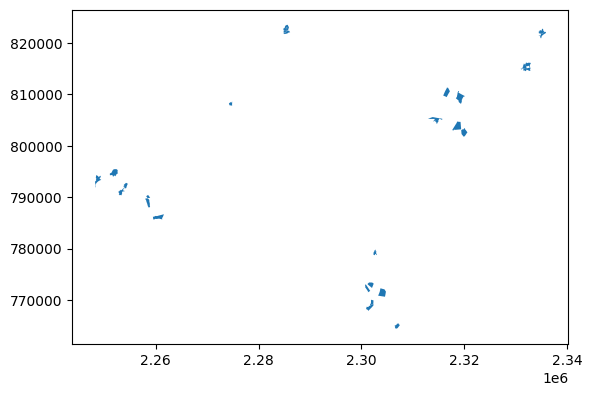

In [348]:
gpdfinal3.plot()

In [349]:
gpdfinal3.head()

,CVEGEO,NOM_MUN,NOM_LOC,POB_TOTAL,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,GM_2020,...,P_15A17,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_15A49_F,P_60YMAS,P_60YMAS_F,AMBITO
0,0601000010288,Colima-VA,Ciudad de Villa de Álvarez,2557.0,1.000000,1.000000,1.000,1.000000,1.000,0.50,...,118,36,40,317,167,124,695,325,154,NaN
1,0600200010483,Colima-VA,Colima,742.0,0.977823,0.972755,0.885,0.965726,0.870,0.50,...,30,10,12,97,49,39,221,58,24,NaN
2,0600200010464,Colima-VA,Colima,90.0,0.639113,0.657921,0.577,0.641129,0.609,0.50,...,3,0,3,3,0,0,18,10,4,NaN
3,0601000010305,Colima-VA,Ciudad de Villa de Álvarez,1115.0,0.659274,0.648840,0.654,0.663306,0.630,0.00,...,35,18,10,156,62,65,360,80,31,NaN
4,0600200011320,Colima-VA,Colima,1520.0,0.597782,0.594349,0.558,0.584677,0.478,0.25,...,43,10,12,167,68,80,384,276,146,NaN


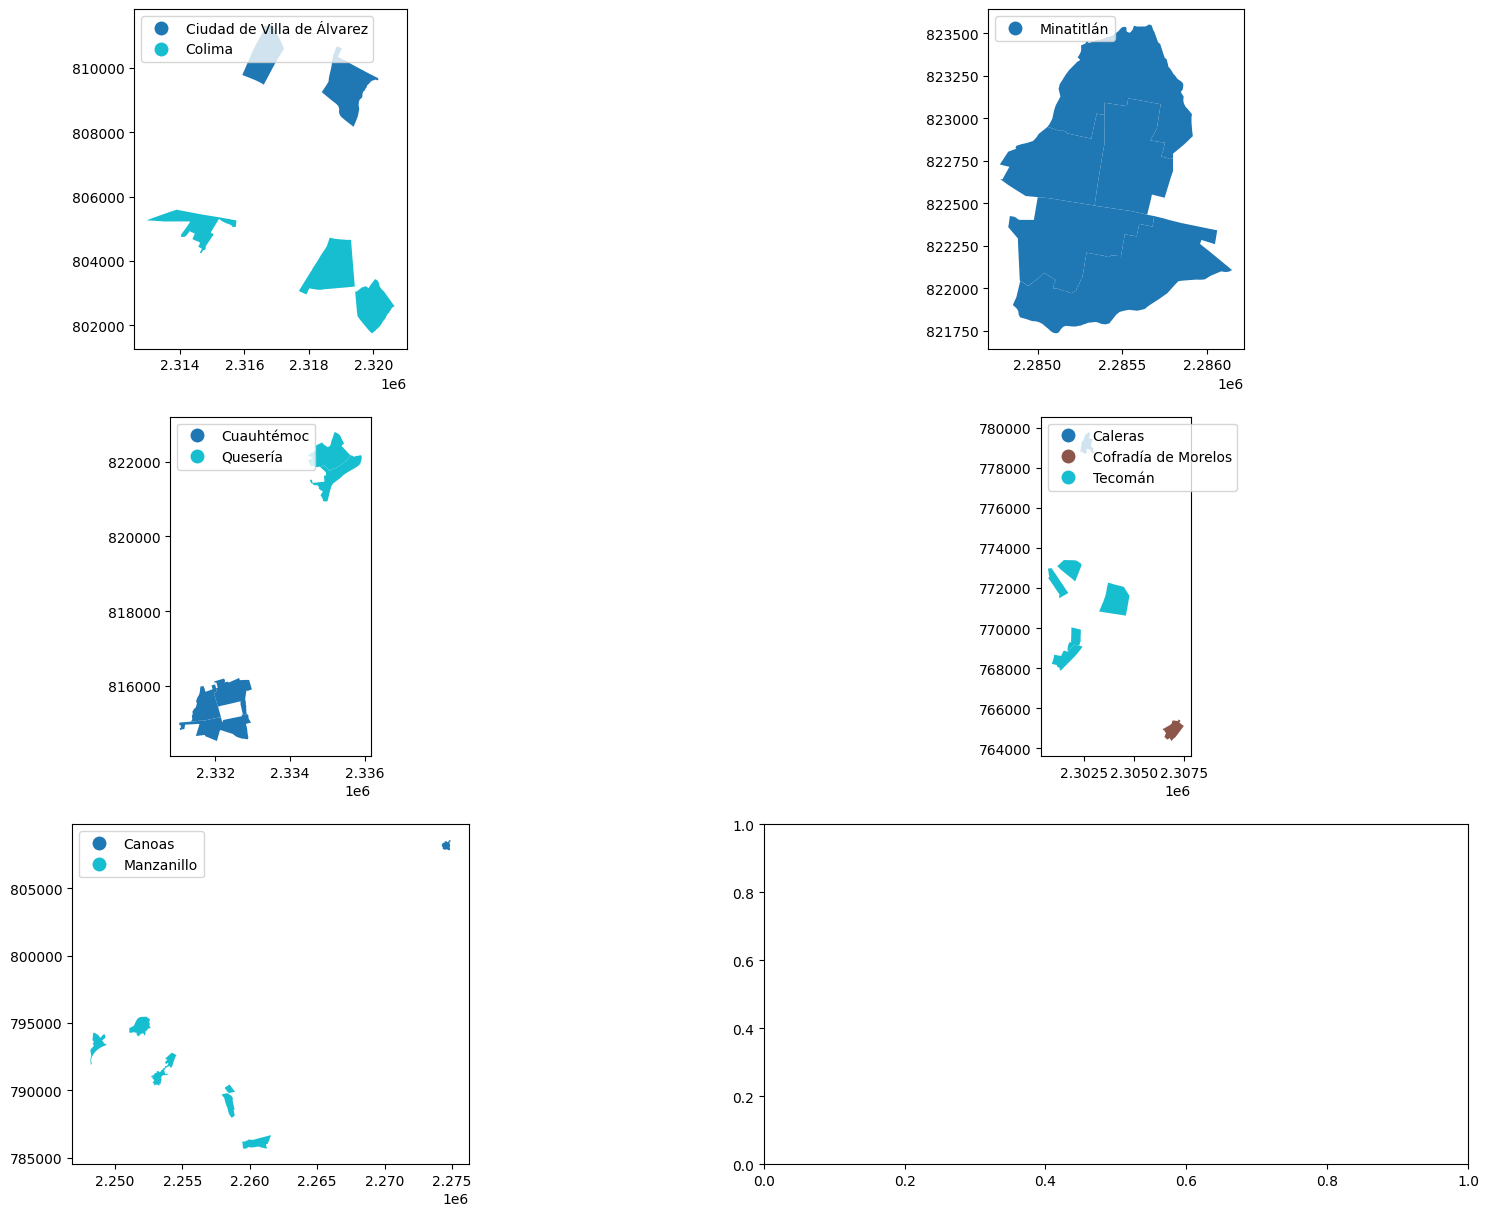

In [350]:

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,15))

i = 0
j = 0

for mun, df in gpdfinal3.groupby("NOM_MUN"):
  df.plot(ax=ax[i,j], label=mun, column="NOM_LOC", legend=True, legend_kwds={'loc': 'upper left'})
  
  i += 1
  if i == 3:
    i = 0
    j += 1


In [351]:
# save gpdfinal3 as gpkg
gpdfinal3.to_file("data/06_colima/colima.gpkg", driver="GPKG")

In [352]:
gpdfinal3.crs

<Derived Projected CRS: PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["ITRF2008",DA ...>
Name: MEXICO_ITRF_2008_LCC
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: International Terrestrial Reference Frame 2008
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [3]:
gpdfinal3 = gpd.read_file("data/06_colima/colima.gpkg")
gpdfinal3.head()

,CVEGEO,NOM_MUN,NOM_LOC,POB_TOTAL,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,GM_2020,...,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_15A49_F,P_60YMAS,P_60YMAS_F,AMBITO,geometry
0,0601000010288,Colima-VA,Ciudad de Villa de Álvarez,2557.0,1.000000,1.000000,1.000,1.000000,1.000,0.50,...,36,40,317,167,124,695,325,154,None,"POLYGON ((2318933.513 810638.283, 2319025.867 ..."
1,0600200010483,Colima-VA,Colima,742.0,0.977823,0.972755,0.885,0.965726,0.870,0.50,...,10,12,97,49,39,221,58,24,None,"POLYGON ((2319196.848 804654.646, 2319197.508 ..."
2,0600200010464,Colima-VA,Colima,90.0,0.639113,0.657921,0.577,0.641129,0.609,0.50,...,0,3,3,0,0,18,10,4,None,"POLYGON ((2320207.018 803190.824, 2320268.911 ..."
3,0601000010305,Colima-VA,Ciudad de Villa de Álvarez,1115.0,0.659274,0.648840,0.654,0.663306,0.630,0.00,...,18,10,156,62,65,360,80,31,None,"POLYGON ((2317155.357 810763.574, 2317160.203 ..."
4,0600200011320,Colima-VA,Colima,1520.0,0.597782,0.594349,0.558,0.584677,0.478,0.25,...,10,12,167,68,80,384,276,146,None,"POLYGON ((2315751.665 805258.386, 2315730.950 ..."


In [7]:
mun_group = gpdfinal3.groupby("NOM_MUN", as_index=False).agg({"POBTOT":"sum"})
mun_group.head()

,NOM_MUN,POBTOT
0,Colima-VA,6024
1,Cuauhtémoc,11817
2,Manzanillo,3612
3,Minatitlán,6018
4,Tecomán,15605


In [8]:
import seaborn as sns

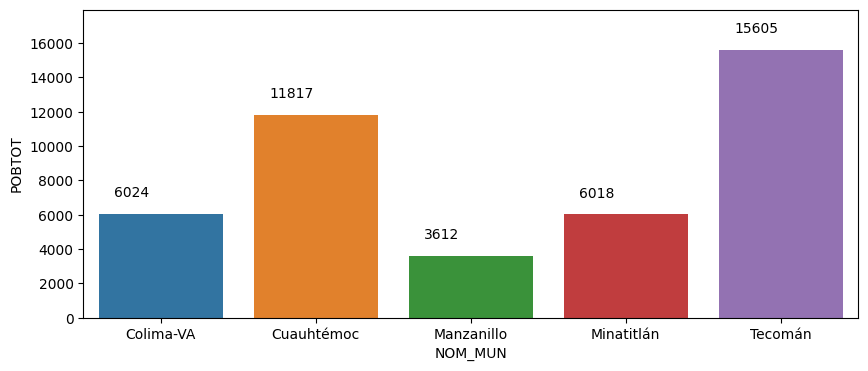

In [16]:
fig, ax = plt.subplots(figsize=(10,4))

sns.barplot(data=mun_group, x="NOM_MUN", y="POBTOT", ax=ax)

# Show values at the top of the bars
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+1000))

# set ylimit from 0 to max value + 15% of max value
ax.set_ylim(0, max(mun_group.POBTOT) * 1.15)

plt.show()